In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.patches as mpatches

from sentiwordnet import SentimentAnalysis
from load_data import load_tweets, load_labelled_data
from tokenizer import apply_keras_tokenizer, load_model_and_tokenizer
from data_modification import aggregate_sentiment
from data_analysis import thresholding
from apply_models import apply_model
from preprocessing import preprocess_tweets, concat_tweet_files
from sentiwordnet import SentimentAnalysis
from models import confusion_matrix

In [ ]:
# Testing accuracy and plotting SentiWordNet

In [4]:
# Load SentiWordNet
s = SentimentAnalysis(filename='data/SentiWordNet.txt',weighting='geometric')

In [7]:
# Load labelled tweets
df_tweets = load_labelled_data('data/sentiment_data_1500_manual.csv')

In [8]:
# Label the manually labelled dataset with SentiWordNet
df_tweets['sentiwordnet'] = [s.score(tweet) for tweet in df_tweets['text']]

In [19]:
# Label the manually labelled dataset with RandomForest
my_model, my_tokenizer = load_model_and_tokenizer('models_and_tokenizers/randomforest.sav', 'models_and_tokenizers/tokenizer_1500_man.sav')
my_tokenized_tweets = apply_keras_tokenizer(df_tweets, my_tokenizer)
my_tweets = apply_model(df_tweets, my_tokenized_tweets, my_model)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [12]:
# Randomize the labelled tweets within their frame
df_tweets_rand_neut = df_tweets[0:500].sample(n=500)
df_tweets_rand_pos = df_tweets[500:1000].sample(n=500)
df_tweets_rand_neg = df_tweets[1000:1500].sample(n=500)
df_tweets = pd.concat([df_tweets_rand_neg, df_tweets_rand_neut, df_tweets_rand_pos]).reset_index()

In [169]:
# Apply thresholding and print confusion matrix
df_tweets['sentiwordnet_thr'] = df_tweets['sentiwordnet'].apply(thresholding, args = (0.02,0.02))
conf = confusion_matrix(df_tweets['sentiwordnet_thr'].astype('int64'), df_tweets['label'],3)
print(conf)
print('Accuracy: ',np.sum(np.diag(conf))/np.sum(conf))

Confusion Matrix: 
[[ 336.  103.   61.]
 [ 205.  233.   62.]
 [ 121.   13.  366.]]
[[ 336.  103.   61.]
 [ 205.  233.   62.]
 [ 121.   13.  366.]]
Accuracy:  0.623333333333


In [157]:
#Check spread
df_tweets['sentiwordnet_thr'].value_counts()

1     798
-1    489
0     213
Name: sentiwordnet_thr, dtype: int64

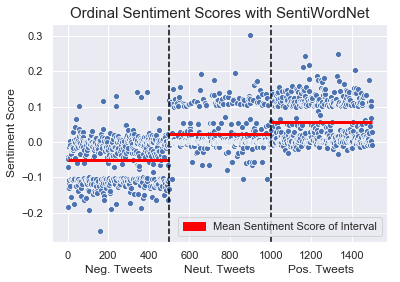

In [64]:
#Scatterplot with means for the ordered labelled tweets
sns.scatterplot(x=df_tweets.index, y=df_tweets['sentiwordnet'])
plt.hlines(y=np.mean(df_tweets_rand_neg['sentiwordnet']), xmin=0, xmax=500, linewidth=3, color='red', label='test')
plt.hlines(y=np.mean(df_tweets_rand_neut['sentiwordnet']), xmin=500, xmax=1000, linewidth=3, color='red')
plt.hlines(y=np.mean(df_tweets_rand_pos['sentiwordnet']), xmin=1000, xmax=1500, linewidth=3, color='red')
plt.axvline(x=500, linewidth=1.5, color='black', linestyle = 'dashed')
plt.axvline(x=1000, linewidth=1.5, color='black', linestyle = 'dashed')
plt.ylabel('Sentiment Score', fontsize=12)
plt.title("Ordinal Sentiment Scores with SentiWordNet", fontsize=15)
plt.text(250, -0.37, 'Neg. Tweets', ha='center', fontsize = 12)
plt.text(750, -0.37, 'Neut. Tweets', ha='center', fontsize = 12)
plt.text(1250, -0.37, 'Pos. Tweets', ha='center', fontsize = 12)
red_patch = mpatches.Patch(color='red', label='Mean Sentiment Score of Interval')
plt.legend(handles=[red_patch])
plt.show()